# ECG Train Model V1

## Import Libraries and setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy

import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (10,5)

## Main Functions

In [2]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [4]:
def correct_rpeaks(signal, rpeaks=None, sampling_rate=100, tol=0.05):
    """Correct R-peak locations to the maximum within a tolerance.
    Parameters
    ----------
    signal : array
        ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    tol : int, float, optional
        Correction tolerance (seconds).
    Returns
    -------
    rpeaks : array
        Cerrected R-peak location indices.
    Notes
    -----
    * The tolerance is defined as the time interval :math:`[R-tol, R+tol[`.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peaks.")

    tol = int(tol * sampling_rate)
    length = len(signal)

    newR = []
    for r in rpeaks:
        a = r - tol
        if a < 0:
            continue
        b = r + tol
        if b > length:
            break
        newR.append(a + np.argmax(signal[a:b]))

    newR = sorted(list(set(newR)))
    newR = np.array(newR, dtype='int')

    return newR

In [5]:
def _extract_heartbeats(signal=None, rpeaks=None, before=200, after=400):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    before : int, optional
        Number of samples to include before the R peak.
    after : int, optional
        Number of samples to include after the R peak.
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR

In [6]:
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.2, after=0.4):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    before : float, optional
        Window size to include before the R peak (seconds).
    after : int, optional
        Window size to include after the R peak (seconds).
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return templates, newR

In [7]:
def get_complete_Heartbit(sample, sampling_rate=100,plot=True):
    filtered_sample = filter_data(sample,sampling_rate)
    data = filtered_sample.T
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    rpeaks = correct_rpeaks(signal=data,rpeaks=peaks, sampling_rate=100,tol=0.05)
    templates, rpeaks = extract_heartbeats(signal=data,rpeaks=rpeaks,sampling_rate=100,before=0.2,after=0.4)
    if plot:
        ts_tmpl = np.linspace(-0.2, 0.4, templates.shape[1], endpoint=False)
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 2)
        ax4 = fig.add_subplot(gs[1:5, 1])
        plt.plot(ts_tmpl, templates.T, 'm', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.set_title('Templates')
        ax4.grid()
    #return templates, rpeaks
    return templates

## Import dataset

In [8]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
del df["Unnamed: 0"]
df.shape

(21837, 1006)

In [9]:
df.head(2)

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,-0.117,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
1,2,19.0,0,NaN,70.0,OTHER,0.004,-0.020,-0.053,-0.056,...,-0.035,-0.045,0.004,0.044,0.507,0.554,0.316,0.121,-0.326,-0.348


In [10]:
df.rhythm_diag.value_counts()

SR       16782
OTHER     3541
AFIB      1514
Name: rhythm_diag, dtype: int64

## Prepare data and split SR/AFIB

In [11]:
df = df.loc[df.rhythm_diag != 'OTHER']

In [12]:
df.rhythm_diag.value_counts()

SR      16782
AFIB     1514
Name: rhythm_diag, dtype: int64

In [13]:
df['rhythm_diag'] = df['rhythm_diag'].map(dict(AFIB=1, SR=0))

In [14]:
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [15]:
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)
df=pd.concat([df_minority,maj_class])

In [16]:
df.rhythm_diag.value_counts()

0    1514
1    1514
Name: rhythm_diag, dtype: int64

In [17]:
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape

(1514, 1000)

In [18]:
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [19]:
X_sr = df_sr.values
X_afib = df_afib.values

In [20]:
X_sr[0].shape

(1000,)

## Get individuals HeartBeats

In [21]:
def get_heart_beat(data):
    templates = []
    templates_aux = []
    for i in range(len(data)-1): 
        templates_aux = get_complete_Heartbit(data[i], 100,False)
        k = len(templates);
        for j in range(len(templates_aux)-1):
            templates.append(templates_aux[j])
    return np.array(templates)

In [22]:
X_sr = get_heart_beat(X_sr)
X_sr.shape

(15369, 60)

In [23]:
y_sr = np.zeros(len(X_sr))
y_sr.shape

(15369,)

In [24]:
X_afib = get_heart_beat(X_afib)
X_afib.shape

(19039, 60)

In [25]:
y_afib = np.ones(len(X_afib))
y_afib.shape

(19039,)

In [26]:
X = np.concatenate((X_sr, X_afib), axis=0)
X.shape

(34408, 60)

In [27]:
y = np.concatenate((y_sr, y_afib), axis=0)
y.shape

(34408,)

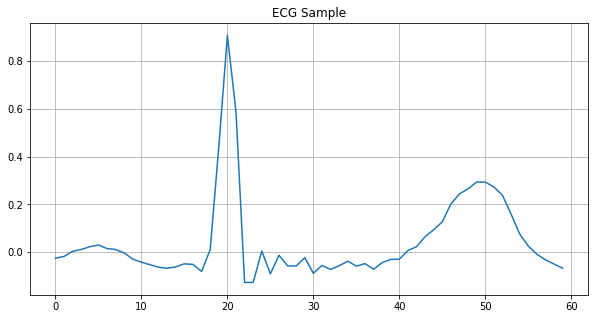

In [28]:
plt.plot(X[2909])
plt.title("ECG Sample")
plt.grid()
plt.show()

## Split and normalize data 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20,
                                                    random_state=21)

In [30]:
print (X_train.min(), X_train.max())
print (X_test.min(), X_test.max())

-2.224608124516127 2.5213715388142184
-2.0953599175448696 2.2400050655566703


In [31]:
X_train = X_train - X_train.min()
X_train = X_train/X_train.max()
print (X_train.min(), X_train.max())

0.0 1.0


Normalize X_test with X_train parameters

In [32]:
X_test = X_test - X_test.min()
X_test = X_test/X_test.max()
print (X_test.min(), X_test.max())

0.0 1.0


## Create DNN Model

In [32]:
X_train.shape

(27526, 60)

In [33]:
input_shape = X.shape[1]

In [34]:
def creating_DNN_model(input_shape, lr=0.001, dropout=0.2):
    model = Sequential()

    model.add(Dense(units=64, activation='relu', input_shape=[input_shape]))
    model.add(Dropout(dropout))   
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    # For a binary classification problem
    opt = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [35]:
model = creating_DNN_model(input_shape, lr=0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3904      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [36]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=25)

In [37]:
EPOCHS = 500

In [38]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    validation_split=0.2, 
                    verbose=0,
                    callbacks=[early_stop]
                    )

Epoch 00334: early stopping


In [43]:
# summarize history for loss
def summarize_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

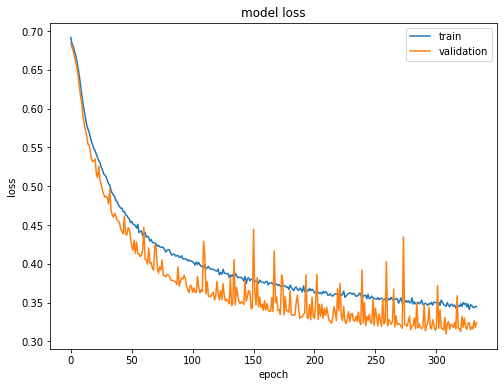

In [40]:
summarize_loss(history)

## Evaluate Model

In [41]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
round (model_accuracy,2)

0.86

In [42]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

In [112]:
y_pred

array([[0.92187536],
       [0.14242327],
       [0.5671133 ],
       ...,
       [0.9057065 ],
       [0.46823552],
       [0.8934425 ]], dtype=float32)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85      3083
         1.0       0.87      0.88      0.88      3799

    accuracy                           0.86      6882
   macro avg       0.86      0.86      0.86      6882
weighted avg       0.86      0.86      0.86      6882



In [46]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

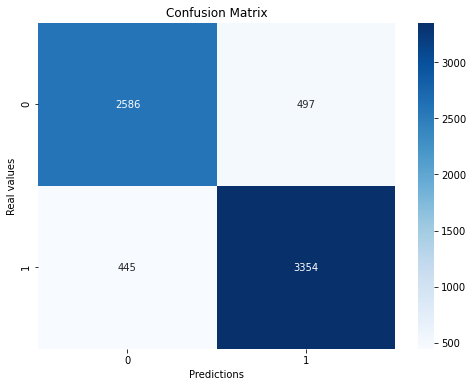

In [45]:
plot_conf_matrix(y_test, y_pred)

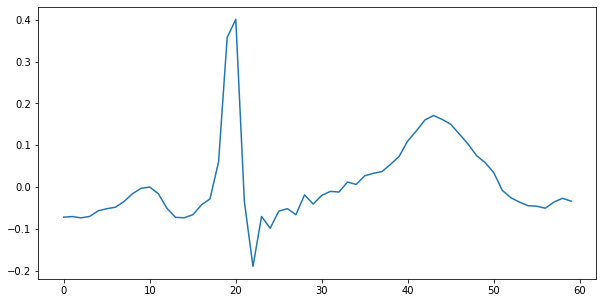

In [51]:
plt.plot(X_sr[29])

In [117]:
y_pred = model.predict(X_test)

In [118]:
y_pred[:10]

array([[0.92187536],
       [0.14242327],
       [0.5671133 ],
       [0.09321621],
       [0.889151  ],
       [0.13092467],
       [0.7882538 ],
       [0.25608784],
       [0.05014819],
       [0.91999066]], dtype=float32)

In [119]:
y_test[:10]

array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])

In [120]:
y_pred = y_pred > 0.5
y_pred[:10]

array([[ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True]])

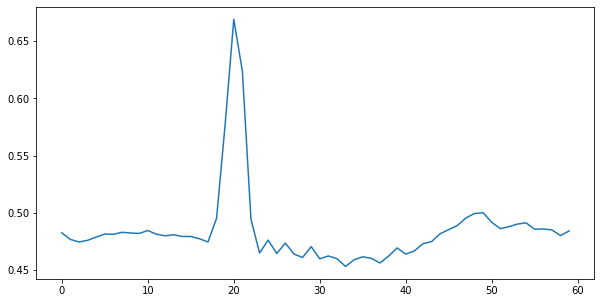

In [122]:
plt.plot(X_test[0])

In [128]:
predictionXy = model.predict(X_sr)

In [129]:
predictionXy[:20]

array([[0.8645451 ],
       [0.7534262 ],
       [0.9781506 ],
       [0.75699365],
       [0.5230733 ],
       [0.8591238 ],
       [0.7613734 ],
       [0.78201455],
       [0.8337507 ],
       [0.97745717],
       [0.88134134],
       [0.9628266 ],
       [0.902959  ],
       [0.72421515],
       [0.9905981 ],
       [0.9181205 ],
       [0.97274697],
       [0.08810252],
       [0.04825422],
       [0.04642826]], dtype=float32)

In [114]:
X_sr[2:4].shape

(2, 60)

In [105]:
predictionX.shape

()

In [110]:
predictionX[:10]

array([[0.8645451 ],
       [0.7534262 ],
       [0.9781506 ],
       [0.75699365],
       [0.5230733 ],
       [0.8591238 ],
       [0.7613734 ],
       [0.78201455],
       [0.8337507 ],
       [0.97745717]], dtype=float32)

In [103]:
lengthpredictionX = len(predictionX)
arrayWrongPredictions = []
for i in range(lengthpredictionX):
    if(predictionX[i][0] < 0.5):
        arrayWrongPredictions.append(predictionX[i][0])
predictionX[99]

array([3.0482803e-07], dtype=float32)

In [112]:
model.save('../models/dnn_v1.h5')

# Model CNN - 1D
Based on: [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

<img src="../models/cnn_v1.h5.png">

In [33]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [34]:
print(X_train.shape, X_test.shape)

(27526, 60, 1) (6882, 60, 1)


In [35]:
samples, features, depht = X_train.shape

In [36]:
def group_layer(model):
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [37]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model=group_layer(model)
model=group_layer(model)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 32)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 32)            5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12, 32)            5

In [38]:
lr = 0.001

In [39]:
opt = Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [40]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=25)

In [41]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
689/689 [==============================] - 10s 10ms/step - loss: 0.6248 - accuracy: 0.6363 - val_loss: 0.4665 - val_accuracy: 0.7950
Epoch 2/100
689/689 [==============================] - 6s 9ms/step - loss: 0.3816 - accuracy: 0.8451 - val_loss: 0.3207 - val_accuracy: 0.8758
Epoch 3/100
689/689 [==============================] - 8s 11ms/step - loss: 0.3308 - accuracy: 0.8712 - val_loss: 0.3419 - val_accuracy: 0.8587
Epoch 4/100
689/689 [==============================] - 8s 12ms/step - loss: 0.3083 - accuracy: 0.8782 - val_loss: 0.2973 - val_accuracy: 0.8825
Epoch 5/100
689/689 [==============================] - 8s 12ms/step - loss: 0.2928 - accuracy: 0.8835 - val_loss: 0.2879 - val_accuracy: 0.8867
Epoch 6/100
689/689 [==============================] - 8s 12ms/step - loss: 0.2863 - accuracy: 0.8846 - val_loss: 0.2866 - val_accuracy: 0.8936
Epoch 7/100
689/689 [==============================] - 7s 10ms/step - loss: 0.2823 - accuracy: 0.8884 - val_loss: 0.2655 - val_accuracy:

689/689 [==============================] - 6s 9ms/step - loss: 0.1604 - accuracy: 0.9378 - val_loss: 0.2129 - val_accuracy: 0.9223
Epoch 58/100
689/689 [==============================] - 6s 9ms/step - loss: 0.1606 - accuracy: 0.9374 - val_loss: 0.2238 - val_accuracy: 0.9161
Epoch 59/100
689/689 [==============================] - 7s 9ms/step - loss: 0.1574 - accuracy: 0.9397 - val_loss: 0.2270 - val_accuracy: 0.9235
Epoch 60/100
689/689 [==============================] - 6s 9ms/step - loss: 0.1574 - accuracy: 0.9399 - val_loss: 0.2442 - val_accuracy: 0.9145
Epoch 61/100
689/689 [==============================] - 6s 9ms/step - loss: 0.1608 - accuracy: 0.9381 - val_loss: 0.1999 - val_accuracy: 0.9263
Epoch 62/100
689/689 [==============================] - 6s 9ms/step - loss: 0.1524 - accuracy: 0.9407 - val_loss: 0.1979 - val_accuracy: 0.9259
Epoch 63/100
689/689 [==============================] - 6s 8ms/step - loss: 0.1551 - accuracy: 0.9395 - val_loss: 0.2084 - val_accuracy: 0.9259
Epoch

Model Accuraccy:  0.92


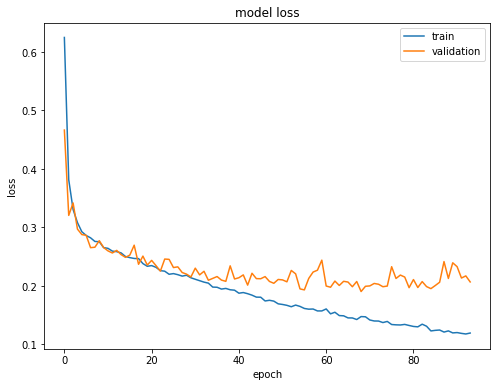

In [44]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

`Maybe train again with lower lr`

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      3083
         1.0       0.93      0.91      0.92      3799

    accuracy                           0.92      6882
   macro avg       0.92      0.92      0.92      6882
weighted avg       0.92      0.92      0.92      6882



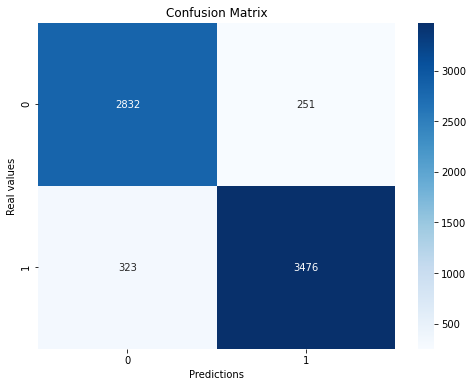

In [47]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print(classification_report(y_test, y_pred))
plot_conf_matrix(y_test, y_pred)

In [48]:
X_test.shape

(6882, 60, 1)

In [50]:
for i in range(10):
    ecg_pred = model.predict(X_sr[i].T.reshape(1,60,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    print(ecg_pred)

True
False
True
True
True
True
True
True
True
True


In [172]:
dfHome = pd.read_csv("ecg_homecare_data_10_s_100Hz_ADS1115.csv")

In [173]:
dfHome

,time,Unnamed: 1,samples
0,15:56:57,57417.70,23
1,15:56:57,57417.70,36
2,15:56:57,57417.71,39
3,15:56:57,57417.72,55
4,15:56:57,57417.73,72
...,...,...,...
12960,15:59:07,57547.32,30
12961,15:59:07,57547.32,40
12962,15:59:07,57547.34,43
12963,15:59:07,57547.34,42


In [175]:
XhomeMeasure = dfHome.samples.values

In [176]:
XhomeMeasure.shape

(12965,)

In [189]:
int(12965/1000)

12

In [197]:
XhomeMeasure = XhomeMeasure/XhomeMeasure.max()

858
1.0


In [201]:
XhomeMeasure[0:100]

array([ 0.02680653,  0.04195804,  0.04545455,  0.06410256,  0.08391608,
        0.1048951 ,  0.12587413,  0.16200466,  0.17132867,  0.12121212,
        0.04312354, -0.01282051, -0.01748252, -0.01398601, -0.01048951,
       -0.02331002, -0.05361305, -0.09090909, -0.1025641 , -0.08857809,
       -0.06410256, -0.03846154, -0.00815851,  0.01515152,  0.05244755,
        0.03846154,  0.        , -0.04195804, -0.03729604,  0.01165501,
        0.04195804,  0.06293706,  0.06410256,  0.06293706,  0.07226107,
        0.08158508,  0.1013986 ,  0.09090909,  0.05477855,  0.04312354,
        0.05594406,  0.05944056,  0.03263403,  0.01515152,  0.05361305,
        0.08275058,  0.07925408,  0.05128205, -0.004662  , -0.05710956,
       -0.0979021 , -0.09440559, -0.07692308, -0.05710956, -0.03846154,
       -0.02097902, -0.01864802, -0.00815851,  0.12121212,  0.52097902,
        0.87995338,  0.67482517, -0.05944056, -0.60722611, -0.5955711 ,
       -0.28787879, -0.1013986 , -0.01048951,  0.01398601,  0.01

In [67]:
model.save('models/cnn_v1.h5')

## Simple CNN

In [68]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model.add(
    Conv1D(32,
           kernel_size=3,
           strides=1,
           padding='same',
           activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 60, 32)            128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 58, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1856)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                59424     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 59,585
Trainable params: 59,585
Non-trainable params: 0
_________________________________________________________________


In [69]:
lr = 0.001
EPOCHS=100

Epoch 1/100
689/689 [==============================] - 3s 4ms/step - loss: 0.6746 - accuracy: 0.5663 - val_loss: 0.6380 - val_accuracy: 0.6028
Epoch 2/100
689/689 [==============================] - 2s 3ms/step - loss: 0.5828 - accuracy: 0.7197 - val_loss: 0.5492 - val_accuracy: 0.7219
Epoch 3/100
689/689 [==============================] - 2s 3ms/step - loss: 0.4989 - accuracy: 0.7850 - val_loss: 0.4598 - val_accuracy: 0.8100
Epoch 4/100
689/689 [==============================] - 2s 3ms/step - loss: 0.4542 - accuracy: 0.8191 - val_loss: 0.4335 - val_accuracy: 0.8347
Epoch 5/100
689/689 [==============================] - 2s 3ms/step - loss: 0.4275 - accuracy: 0.8348 - val_loss: 0.4184 - val_accuracy: 0.8345
Epoch 6/100
689/689 [==============================] - 2s 3ms/step - loss: 0.4143 - accuracy: 0.8457 - val_loss: 0.3915 - val_accuracy: 0.8551
Epoch 7/100
689/689 [==============================] - 2s 3ms/step - loss: 0.4008 - accuracy: 0.8518 - val_loss: 0.3857 - val_accuracy: 0.8651

Epoch 58/100
689/689 [==============================] - 2s 4ms/step - loss: 0.2611 - accuracy: 0.9021 - val_loss: 0.2554 - val_accuracy: 0.9027
Epoch 59/100
689/689 [==============================] - 2s 3ms/step - loss: 0.2615 - accuracy: 0.9008 - val_loss: 0.2515 - val_accuracy: 0.9034
Epoch 60/100
689/689 [==============================] - 2s 3ms/step - loss: 0.2568 - accuracy: 0.9037 - val_loss: 0.2571 - val_accuracy: 0.9028
Epoch 61/100
689/689 [==============================] - 2s 3ms/step - loss: 0.2563 - accuracy: 0.9035 - val_loss: 0.2514 - val_accuracy: 0.9039
Epoch 62/100
689/689 [==============================] - 2s 3ms/step - loss: 0.2568 - accuracy: 0.9024 - val_loss: 0.2660 - val_accuracy: 0.8990
Epoch 63/100
689/689 [==============================] - 2s 4ms/step - loss: 0.2578 - accuracy: 0.9030 - val_loss: 0.2496 - val_accuracy: 0.9076
Epoch 64/100
689/689 [==============================] - 2s 4ms/step - loss: 0.2571 - accuracy: 0.9026 - val_loss: 0.2698 - val_accuracy:

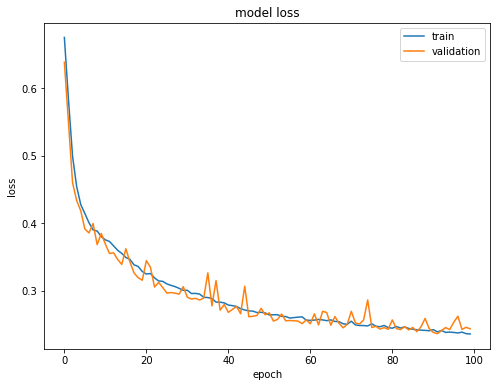

In [70]:
opt = Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=25)

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

In [71]:
model.save('models/cnn_v0.h6')

INFO:tensorflow:Assets written to: models/cnn_v0.h6\assets


In [160]:
model_cnn_v0 = load_model('../models/cnn_v0.h5')
model_cnn_v0.save('../models/cnn_v0')

INFO:tensorflow:Assets written to: ../models/cnn_v0/assets


# Converting model to TF-Lite and TF-Micro

In [163]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [171]:
# Convert TF model to a tflite model
model_cnn_v0 = load_model('../models/cnn_v0')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/cnn_v0.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/ss/f643n9x53s754jfn9_g46s800000gn/T/tmprhz0tfp2/assets


INFO:tensorflow:Assets written to: /var/folders/ss/f643n9x53s754jfn9_g46s800000gn/T/tmprhz0tfp2/assets


63904

In [172]:
c_model_name = '../models/cnn_v0'

In [173]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

`The model has 59K trainable params and uses 394Kb of memory`

### CNN V1

In [174]:
c_model_name = '../models/cnn_v1'

In [170]:
model_cnn_v1 = load_model('../models/cnn_v1.h5')
model_cnn_v1.save('../models/cnn_v1')

INFO:tensorflow:Assets written to: ../models/cnn_v1/assets


INFO:tensorflow:Assets written to: ../models/cnn_v1/assets


In [175]:
# Convert TF model to a tflite model
model_cnn_v1 = load_model('../models/cnn_v1')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/cnn_v1.tflite","wb").write(tflite_model)

with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

INFO:tensorflow:Assets written to: /var/folders/ss/f643n9x53s754jfn9_g46s800000gn/T/tmp2de5tslx/assets


INFO:tensorflow:Assets written to: /var/folders/ss/f643n9x53s754jfn9_g46s800000gn/T/tmp2de5tslx/assets


`The model has 31K trainable params and uses 289Kb of memory`